check that any new vein is not super close to existing veins - investigate why this happens

In [1]:
!pip install networkx[default]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math

In [6]:
veins = nx.DiGraph()
veins.add_node(0, x=0, y=0)

In [33]:
def resetSimulation(veins, auxinSources, x, y):
    veins = nx.DiGraph()
    veins.add_node(0, x=0, y=0)

    auxinSources = []

    # Create points for the curve
    t = np.linspace(0.0001, 1, 100)  # not including 0 because 0 is leaf stem not where leaf grows.
    x = np.sin(np.pi * t) * (1 - t)
    y = t
    # Create the mirror image by reversing the sign of x
    # This combines the right side (original x values) with the left side (-x values)
    x = np.concatenate([x, -x[::-1]])  # [::-1] reverses the array
    y = np.concatenate([y, y[::-1]])   # Mirror the y values too to complete the loop
    return veins, auxinSources, x, y

In [3]:
def getVeinPositionList(veins):
    x,y = [], []
    for i in veins.nodes():
        x.append(veins.nodes[i]['x'])
        y.append(veins.nodes[i]['y'])
    return x,y

In [101]:
def plot_leaf(x, y, veins, auxinSourceX, auxinSourceY):
    # Plot the complete leaf shape
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.plot(x, y)
    ax.set_title("Complete Leaf Shape")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True)
    ax.axis('equal')  # This ensures the aspect ratio is 1:1

    veinsX, veinsY = getVeinPositionList(veins)
    ax.plot(veinsX,veinsY, 'go')
    nx.draw_networkx_edges(veins, pos=dict(zip(veins.nodes, zip(veinsX, veinsY))), width=list(nx.get_edge_attributes(veins, 'width').values()), arrows=False, ax=ax)

    ax.plot(auxinSourceX, auxinSourceY, 'ro')
    plt.show()

In [58]:
def scaleGrowth(baseX, baseY, x, y, scalingFactor):
    x = baseX + scalingFactor * (x - baseX)
    y = baseY + scalingFactor * (y - baseY)
    return x, y

def growLeaf(baseX, baseY, x, y, timestep):
    # scalingFactor,growthOfScalingFactor = updateScalingFactor(scalingFactor, growthOfScalingFactor, deltaScalingFactor)
    scalingFactor = 1 + getGrowthForTimestep(timestep)
    x, y = scaleGrowth(baseX, baseY, x, y, scalingFactor)
    return x,y

In [153]:
baseX, baseY = 0.0, 0.0
sourceToVeinDistanceThreshold = 0.1
sourceToSourceDistanceThreshold = 0.1
distanceVeinGrows = 0.1
numberOfAuxinSources = 10
murraysLawExponent = 3

In [9]:
auxinSources = []

def getAuxinSourceX(auxinSources):
    return [x for x,y in auxinSources]

def getAuxinSourceY(auxinSources):
    return [y for x,y in auxinSources]

In [10]:
# Create points for the curve
t = np.linspace(0.0001, 1, 100)  # not including 0 because 0 is leaf stem not where leaf grows.
x = np.sin(np.pi * t) * (1 - t)
y = t
# Create the mirror image by reversing the sign of x
# This combines the right side (original x values) with the left side (-x values)
x = np.concatenate([x, -x[::-1]])  # [::-1] reverses the array
y = np.concatenate([y, y[::-1]])   # Mirror the y values too to complete the loop

In [62]:
scalingFactor = 1.0
growthOfScalingFactor = 0.01
# deltaScalingFactor = lambda f: max(f-max(0.1*f, 0.1), 0)
def deltaScalingFactor(sf):
    print(f'Current {sf}, new {max(sf-0.001, 0)}')
    return max(sf-0.001, 0)

def updateScalingFactor(scalingFactor, growthOfScalingFactor, deltaScalingFactor):
    growthOfScalingFactor = deltaScalingFactor(growthOfScalingFactor)
    scalingFactor += growthOfScalingFactor

    return scalingFactor, growthOfScalingFactor

def getGrowthForTimestep(timestep):
    if timestep > 10:
        return 0
    else:
        return 0.1

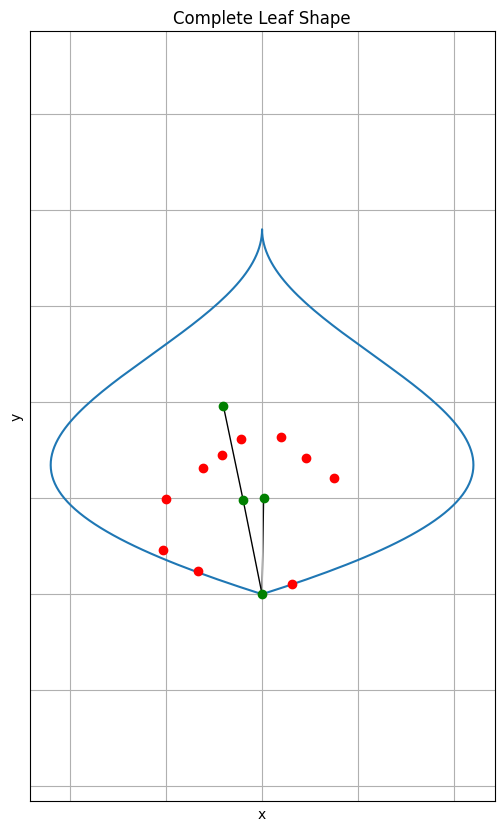

In [ ]:
# x, y, scalingFactor, growthOfScalingFactor = growLeaf(baseX, baseY, x, y, scalingFactor, growthOfScalingFactor, deltaScalingFactor)
# plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

In [12]:
def throwDart(x, y):
    xMin, xMax = np.min(x), np.max(x)
    randomX = np.random.uniform(xMin, xMax)
    xIdx = np.argsort(np.abs(x - randomX))[:2]
    yMin, yMax = np.min(y[xIdx]), np.max(y[xIdx])
    randomY = np.random.uniform(yMin, yMax)

    return randomX, randomY

def throwDartAtEdges(x, y):
    xSorted = x[np.argsort(x)]

    xMin, xMax = xSorted[0], xSorted[-1]
    randomX = np.random.uniform(xMin, xMax)

    xIdx = np.argsort(np.abs(x - randomX))[:2]
    yMin, yMax = np.min(y[xIdx]), np.max(y[xIdx])

    return randomX, random.choice([yMin, yMax])

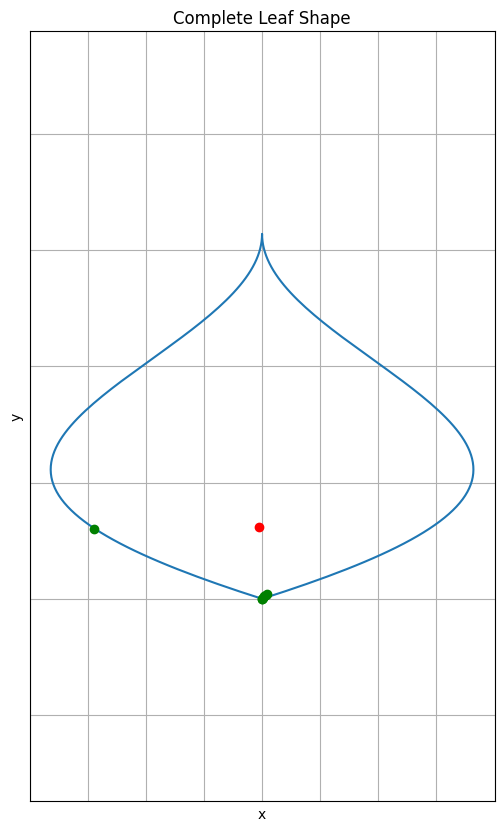

In [ ]:
# newVeinX, newVeinY = throwDartAtEdges(x, y)
# veins.add_node(veins.number_of_nodes(), x=newVeinX, y=newVeinY)
# plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

In [13]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [14]:
def checkNewSourceAgainstOtherVeins(veins, newSourceX, newSourceY, thresholdBirthDistance):
    for i in veins.nodes():
        if distance(veins.nodes[i]['x'], veins.nodes[i]['y'], newSourceX, newSourceY) < thresholdBirthDistance:
            return False
    return True

def checkNewSourceAgainstOtherSources(auxinSources, newSourceX, newSourceY, thresholdDistance):
    for (x,y) in auxinSources:
        if distance(x, y, newSourceX, newSourceY) < thresholdDistance:
            return False
    return True

In [97]:
def removeSourcesCloseToVeins(veins, auxinSources, thresholdDistance):
    newAuxinSources = []
    for i in range(len(auxinSources)):
        isClose = False
        for j in range(len(veins.nodes)):
            if distance(veins.nodes[j]['x'], veins.nodes[j]['y'], auxinSources[i][0], auxinSources[i][1]) <= thresholdDistance:
                isClose = True
                break
        if not isClose:
            newAuxinSources.append(auxinSources[i])
    return newAuxinSources

In [16]:
def addValidAuxinSource(veins, auxinSources, x, y, sourceToVeinDistanceThreshold, sourceToSourceDistanceThreshold):
    while True:
        newSourceX, newSourceY = throwDartAtEdges(x, y)

        if checkNewSourceAgainstOtherVeins(veins, newSourceX, newSourceY, sourceToVeinDistanceThreshold) and checkNewSourceAgainstOtherSources(auxinSources, newSourceX, newSourceY, sourceToSourceDistanceThreshold):
            # veins.add_node(veins.number_of_nodes(), x=newSourceX, y=newSourceY)
            auxinSources.append((newSourceX, newSourceY))
            break

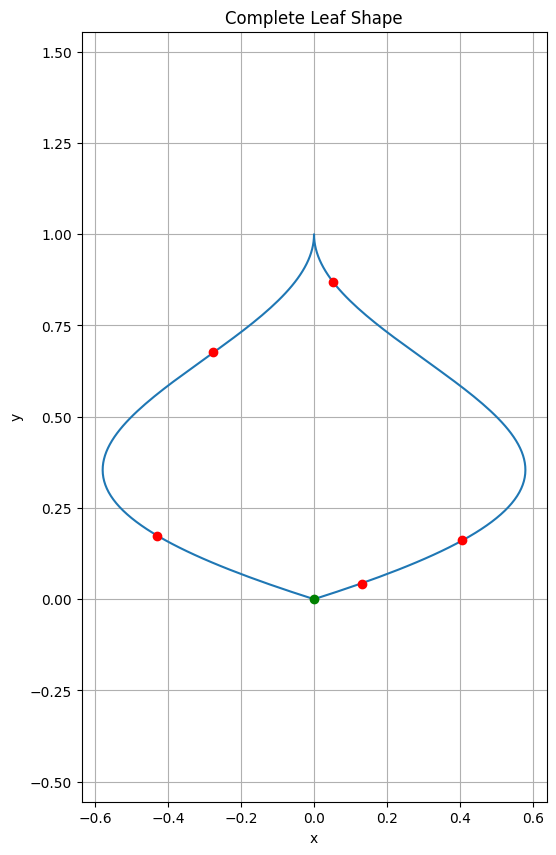

In [45]:
for i in range(5):
    addValidAuxinSource(veins, auxinSources, x, y, sourceToVeinDistanceThreshold, sourceToSourceDistanceThreshold)
plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

In [17]:
def getBuckets(veins, auxinSources):
    buckets = [[] for i in range(veins.number_of_nodes())]

    for sourceX,sourceY in auxinSources:
        minDistance = np.inf
        minIdx = -1
        for i in veins.nodes():
            if distance(veins.nodes[i]['x'], veins.nodes[i]['y'], sourceX, sourceY) < minDistance:
                minDistance = distance(veins.nodes[i]['x'], veins.nodes[i]['y'], sourceX, sourceY)
                minIdx = i

        buckets[minIdx].append((sourceX,sourceY))

    return buckets

In [177]:
def addVeinsForBuckets(buckets, veins, distanceVeinGrows):
    newVeinNodesAdded = []
    for bucketIdx, bucket in enumerate(buckets):
        if len(bucket) == 0:
            continue
        node = veins.nodes[bucketIdx]

        directionVectorX, directionVectorY = getDirectionVector(bucket, node['x'],  node['y'])
        print(f'directionVectorX: {directionVectorX}, directionVectorY: {directionVectorY}')

        newVeinX = node['x'] + distanceVeinGrows * (directionVectorX / math.sqrt(directionVectorX**2 + directionVectorY**2))
        newVeinY = node['y'] + distanceVeinGrows * (directionVectorY / math.sqrt(directionVectorX**2 + directionVectorY**2))

        veins.add_node(veins.number_of_nodes(), x=newVeinX, y=newVeinY)
        veins.add_edge(veins.number_of_nodes() - 1, bucketIdx, width=1)
        newVeinNodesAdded.append(veins.number_of_nodes() - 1)

    return newVeinNodesAdded

In [161]:
def isNewVeinCloseToExistingVeins(veins, newVeinX, newVeinY, thresholdDistance):
    for i in veins.nodes():
        if distance(veins.nodes[i]['x'], veins.nodes[i]['y'], newVeinX, newVeinY) < thresholdDistance:
            return True
    return False

def getDirectionVector(bucket, nodeX, nodeY):
    directionVectorX, directionVectorY = 0, 0
    for sourceX, sourceY in bucket:
        directionVectorX += (sourceX - nodeX) / distance(nodeX, nodeY, sourceX, sourceY)
        directionVectorY += (sourceY - nodeY) / distance(nodeX, nodeY, sourceX, sourceY)

    if abs(directionVectorX) < 0.001:
        print(f'picking random x, before {directionVectorX}')
        directionVectorX += random.choice(bucket)[0]
        print(f'after {directionVectorX}')

    if abs(directionVectorY) < 0.001:
        print(f'picking random y, before {directionVectorY}')
        directionVectorY += random.choice(bucket)[1]
        print(f'after {directionVectorY}')

    return directionVectorX, directionVectorY

In [19]:
def updateWidthForNewVeinNodes(newVeinNodes, veins, murraysLawExponent):
    for newVeinNode in newVeinNodes:
        path = nx.shortest_path(veins, newVeinNode, 0)
        path_edges = list(zip(path, path[1:]))
        for i in range(1, len(path_edges)):
            veins.edges[path_edges[i]]['width'] = min(10, murraysLaw(path_edges[i], veins, murraysLawExponent))

    return veins

def murraysLaw(veinEdge, veins, murraysLawExponent):
    veinEdgeOrigin = veinEdge[0]

    total = 0
    for e in veins.in_edges(veinEdgeOrigin):
        total += veins.edges[e]['width']**murraysLawExponent

    return math.sqrt(total)

In [95]:
print(f'Before removing sources: {auxinSources}')
auxinSources = removeSourcesCloseToVeins(veins, auxinSources, sourceToVeinDistanceThreshold)
print(f'After removing sources: {auxinSources}')

Before removing sources: [(0.05219949365885268, 0.8686999999999999), (-0.2770856602387496, 0.6768)]
After removing sources: [(0.05219949365885268, 0.8686999999999999), (-0.2770856602387496, 0.6768)]


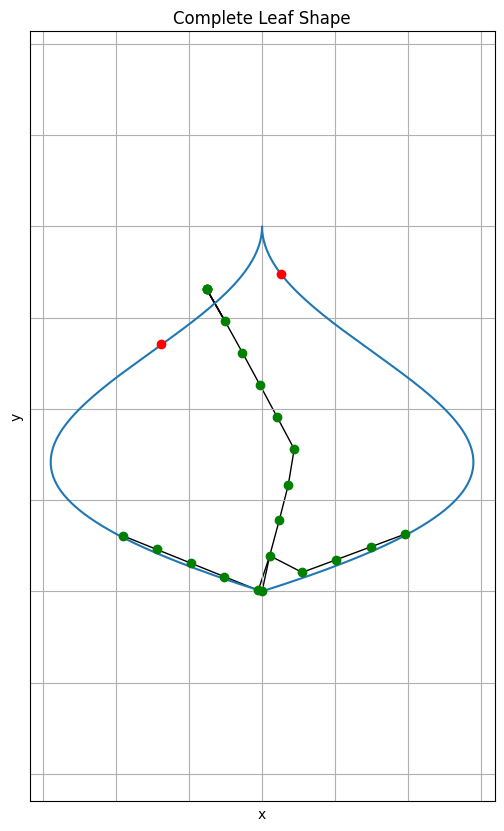

In [96]:
plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

In [ ]:
for i in range(50):
    buckets = getBuckets(veins, auxinSources)
    newVeinNodesAdded = addVeinsForBuckets(buckets, veins, distanceVeinGrows)
    veins = updateWidthForNewVeinNodes(newVeinNodesAdded, veins, murraysLawExponent)

    for j in range(numberOfAuxinSources - len(auxinSources)):
        addValidAuxinSource(veins, auxinSources, x, y, sourceToVeinDistanceThreshold, sourceToSourceDistanceThreshold)

    auxinSources = removeSourcesCloseToVeins(veins, auxinSources, sourceToVeinDistanceThreshold)
    x,y = growLeaf(baseX, baseY, x, y, i)

    plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

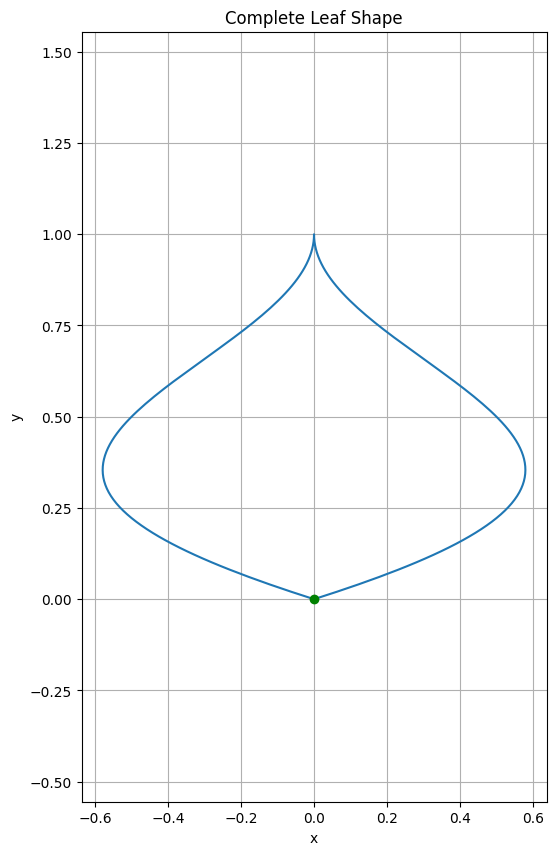

In [178]:
veins, auxinSources, x, y = resetSimulation(veins, auxinSources, x, y)
plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

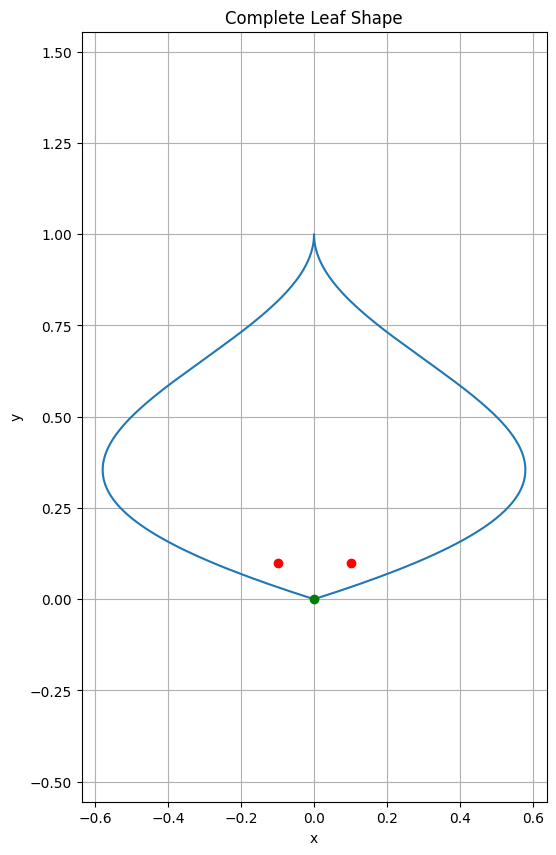

picking random x, before 3.5355073896292666e-06
after 0.10000453550738964


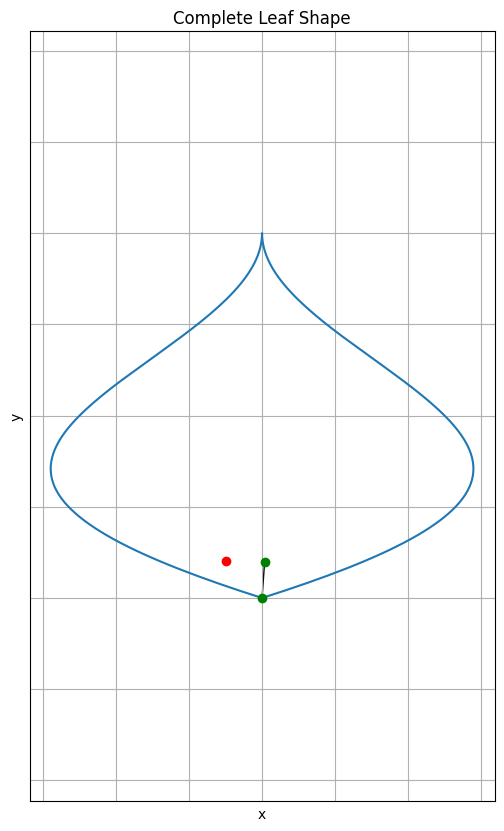

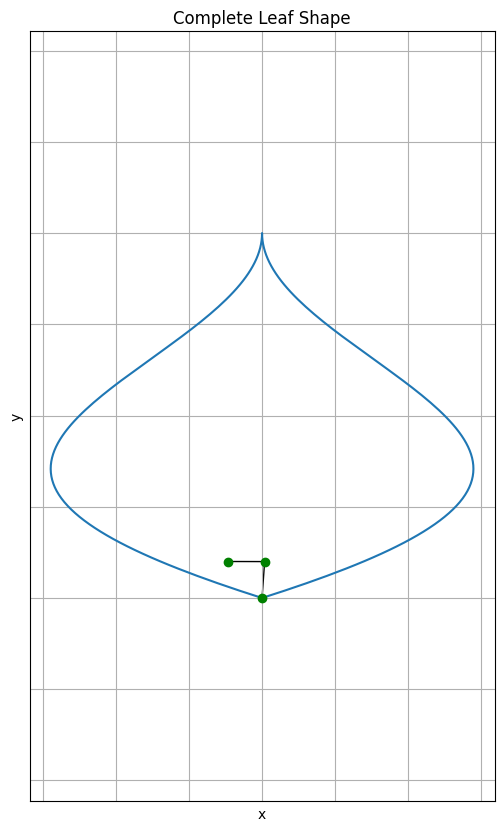

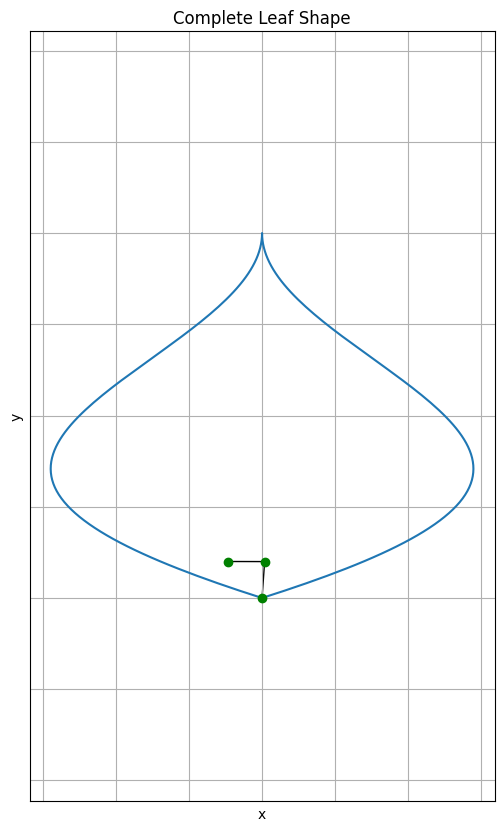

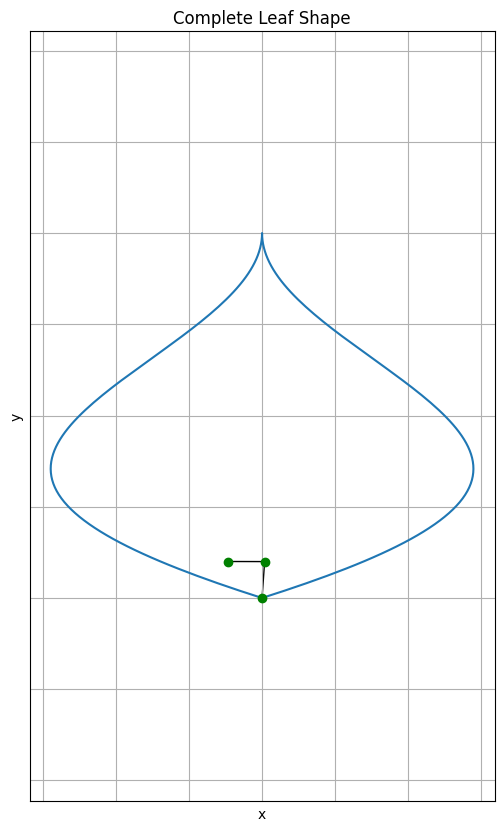

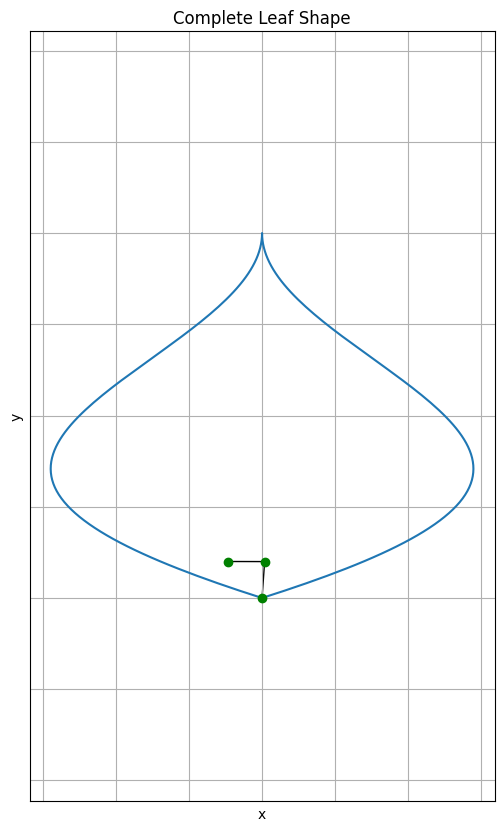

In [176]:
def testVerySmallDirectionVectorForVeinsToSources(veins, auxinSources, x, y):
    veins, auxinSources, x, y = resetSimulation(veins, auxinSources, x, y)

    auxinSources = [[0.100001, 0.1], [-0.1, 0.1]]
    plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

    for i in range(5):
        buckets = getBuckets(veins, auxinSources)
        newVeinNodesAdded = addVeinsForBuckets(buckets, veins, distanceVeinGrows)

        # veinsX, veinsY = getVeinPositionList(veins)
        # print(dict(zip(veins.nodes, zip(veinsX, veinsY))))

        auxinSources = removeSourcesCloseToVeins(veins, auxinSources, sourceToVeinDistanceThreshold)
        plot_leaf(x, y, veins, getAuxinSourceX(auxinSources), getAuxinSourceY(auxinSources))

testVerySmallDirectionVectorForVeinsToSources(veins, auxinSources, x, y)